In [1]:
import utils.feature_extractors as utils
from utils.evaluation import action_evaluator
import numpy as np
import os
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import joblib

In [2]:
config = {
    "model_type":"ExtraTreesClassifier",
    "train_pos_loc":"data/TR_pos_SPIDER.txt",
    "train_neg_loc":"data/TR_neg_SPIDER.txt",
    "test_pos_loc":"data/TS_pos_SPIDER.txt",
    "test_neg_loc":"data/TS_neg_SPIDER.txt",
    "model_save_loc":"model_saves",
    "random_seed":9
}

In [3]:
class SpiderDataGenerator(object):
    ALL_FEAT = ["AAC","DPC","CTD",
                "PAAC","APAAC","RSacid",
                "RSpolar","RSsecond","RScharge",
                "RSDHP"]
    def __init__(self, pos_data_file, neg_data_file,feat_type=None) -> None:
        super(SpiderDataGenerator).__init__()
        self.pos_data_file = pos_data_file
        self.neg_data_file = neg_data_file
        
        assert feat_type in SpiderDataGenerator.ALL_FEAT or feat_type == None
        
        self.feat_type = feat_type
        
        self.pos_data = utils.read_fasta(self.pos_data_file)
        self.neg_data = utils.read_fasta(self.neg_data_file)
        
        self.data = self.pos_data+self.neg_data
        self.targets = np.array([True]*len(self.pos_data)+[False]*len(self.neg_data))
        
        self.raw = [x[1] for x in self.data]
        
        self.feat_AAC = utils.AAC(self.data)[0]
        print("Generating AAC Feature .....")
        self.feat_DPC = utils.DPC(self.data,0)[0]
        print("Generating DPC Feature .....")
        self.feat_CTD = np.hstack((utils.CTDC(self.data)[0], 
                              utils.CTDD(self.data)[0], 
                              utils.CTDT(self.data)[0]))
        print("Generating CTD Feature .....")
        self.feat_PAAC = utils.PAAC(self.data,1)[0]
        print("Generating PAAC Feature .....")
        self.feat_APAAC = utils.APAAC(self.data,1)[0]
        print("Generating APAAC Feature .....")
        self.feat_RSacid = utils.reducedACID(self.data) 
        print("Generating reducedACID Feature .....")
        self.feat_RSpolar = utils.reducedPOLAR(self.data)
        print("Generating reducedPOLAR Feature .....")
        self.feat_RSsecond = utils.reducedSECOND(self.data)
        print("Generating reducedSECOND Feature .....")
        self.feat_RScharge = utils.reducedCHARGE(self.data)
        print("Generating reducedCHARGE Feature .....")
        self.feat_RSDHP = utils.reducedDHP(self.data)
        print("Generating reducedDHP Feature .....")
        
        
        
    
    def get_combination_feature(self,selected:list = None):
        
        all_feat =[self.feat_AAC,self.feat_DPC,self.feat_CTD,
                   self.feat_PAAC,self.feat_APAAC,self.feat_RSacid,
                   self.feat_RSpolar,self.feat_RSsecond,self.feat_RScharge,
                   self.feat_RSDHP]
        
        if selected:
            select_index = sorted([SpiderDataGenerator.ALL_FEAT.index(x) for x in selected])
            all_feat = [all_feat[x] for x in select_index]
            
        return np.concatenate(all_feat,axis=-1)
        
        
        
            
    def __len__(self) -> int:
        return len(self.data)

In [4]:
train_data = SpiderDataGenerator(pos_data_file=config["train_pos_loc"],neg_data_file=config["train_neg_loc"])

Generating AAC Feature .....
Generating DPC Feature .....
Generating CTD Feature .....
Generating PAAC Feature .....
Generating APAAC Feature .....
Generating reducedACID Feature .....
Generating reducedPOLAR Feature .....
Generating reducedSECOND Feature .....
Generating reducedCHARGE Feature .....
Generating reducedDHP Feature .....


In [5]:
X_data = {
    "AAC":train_data.feat_AAC,
    "DPC":train_data.feat_DPC,
    "CTD":train_data.feat_CTD,
    "PAAC":train_data.feat_PAAC,
    "APAAC":train_data.feat_APAAC,
    "RSacid":train_data.feat_RSacid,
    "RSpolar":train_data.feat_RSpolar,
    "RSsecond":train_data.feat_RSsecond,
    "RScharge":train_data.feat_RScharge,
    "RSDHP":train_data.feat_RSDHP,
    "Combine":train_data.get_combination_feature(),
    "DPC_RSDHP_RSacid_RSpolar_RSsecond_RScharge":train_data.get_combination_feature(["DPC","RSDHP","RSacid","RSpolar","RSsecond","RScharge"]),
}
data_pipelines = {
    "AAC":make_pipeline(StandardScaler()),
    "DPC":make_pipeline(StandardScaler()),
    "CTD":make_pipeline(StandardScaler()),
    "PAAC":make_pipeline(StandardScaler()),
    "APAAC":make_pipeline(StandardScaler()),
    "RSacid":make_pipeline(StandardScaler()),
    "RSpolar":make_pipeline(StandardScaler()),
    "RSsecond":make_pipeline(StandardScaler()),
    "RScharge":make_pipeline(StandardScaler()),
    "RSDHP":make_pipeline(StandardScaler()),
    "Combine":make_pipeline(StandardScaler()),
    "DPC_RSDHP_RSacid_RSpolar_RSsecond_RScharge":make_pipeline(StandardScaler()),
    }

Model :- ExtraTreesClassifier, DataType :- AAC


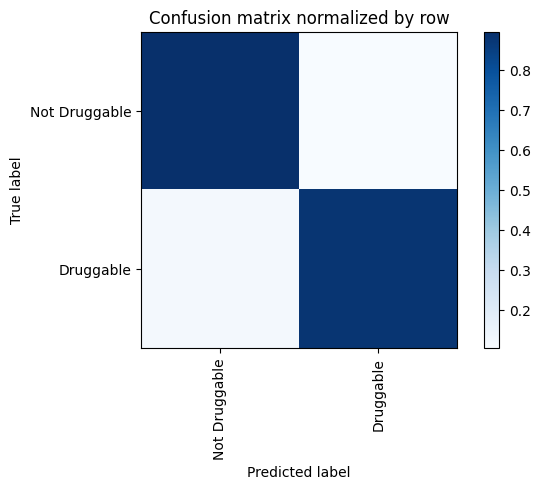

Overall accuracy: 0.888

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.889      0.896      0.892      0.519       1319|	 Druggable: 0.104,	
    Druggable       0.887      0.879      0.883      0.481       1223|	 Not Druggable: 0.121,	

----------------------------------------------------------------------------------------------------
  avg / total       0.888      0.888      0.888        1.0       2542|	      

{'accuracy': 0.8878835562549174, 'precision': 0.8878427504404576, 'recall': 0.8875597670873583, 'f1': 0.8876845549403403, 'sensitivity': 0.8789860997547015, 'specificity': 0.8961334344200151}



Model :- ExtraTreesClassifier, DataType :- DPC


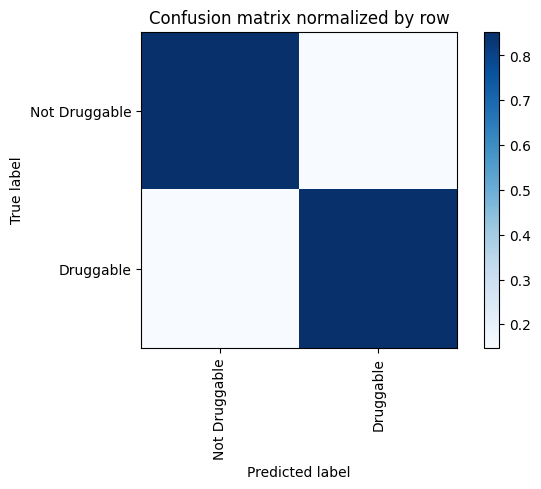

Overall accuracy: 0.852

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.862      0.851      0.856      0.519       1319|	 Druggable: 0.149,	
    Druggable       0.841      0.853      0.847      0.481       1223|	 Not Druggable: 0.147,	

----------------------------------------------------------------------------------------------------
  avg / total       0.852      0.852      0.852        1.0       2542|	      

{'accuracy': 0.8516915814319433, 'precision': 0.8514400921658987, 'recall': 0.8517326798653804, 'f1': 0.8515482014392947, 'sensitivity': 0.8528209321340965, 'specificity': 0.8506444275966641}



Model :- ExtraTreesClassifier, DataType :- CTD


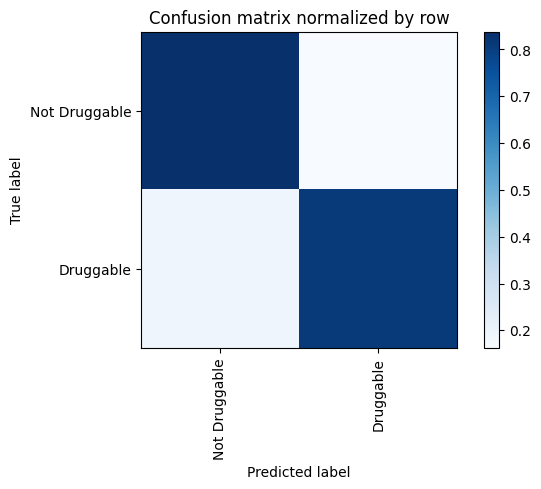

Overall accuracy: 0.824

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.826      0.838      0.832      0.519       1319|	 Druggable: 0.162,	
    Druggable       0.822      0.809      0.816      0.481       1223|	 Not Druggable: 0.191,	

----------------------------------------------------------------------------------------------------
  avg / total       0.824      0.824      0.824        1.0       2542|	      

{'accuracy': 0.8241542092840283, 'precision': 0.8240593139956994, 'recall': 0.8236203744629254, 'f1': 0.8237935755680472, 'sensitivity': 0.8094848732624693, 'specificity': 0.8377558756633814}



Model :- ExtraTreesClassifier, DataType :- PAAC


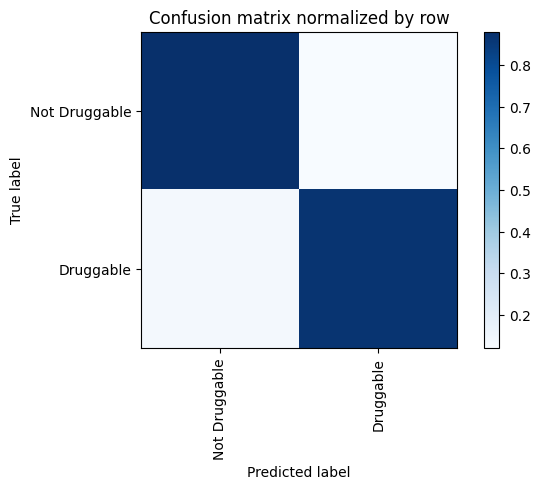

Overall accuracy: 0.874

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.877      0.880      0.879      0.519       1319|	 Druggable: 0.120,	
    Druggable       0.870      0.867      0.868      0.481       1223|	 Not Druggable: 0.133,	

----------------------------------------------------------------------------------------------------
  avg / total       0.874      0.874      0.874        1.0       2542|	      

{'accuracy': 0.8737214791502754, 'precision': 0.8735836818319369, 'recall': 0.8734667297321926, 'f1': 0.8735218116912135, 'sensitivity': 0.866721177432543, 'specificity': 0.8802122820318423}



Model :- ExtraTreesClassifier, DataType :- APAAC


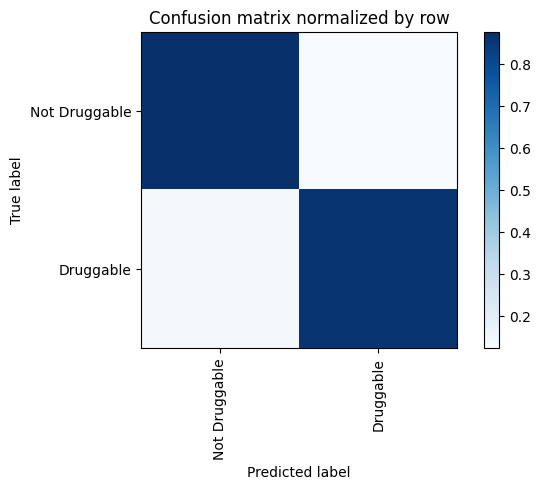

Overall accuracy: 0.869

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.871      0.877      0.874      0.519       1319|	 Druggable: 0.123,	
    Druggable       0.867      0.860      0.863      0.481       1223|	 Not Druggable: 0.140,	

----------------------------------------------------------------------------------------------------
  avg / total       0.869      0.869      0.869        1.0       2542|	      

{'accuracy': 0.8690007867820614, 'precision': 0.8688958883309184, 'recall': 0.868679783552172, 'f1': 0.8687768951743358, 'sensitivity': 0.8601798855273917, 'specificity': 0.8771796815769523}



Model :- ExtraTreesClassifier, DataType :- RSacid


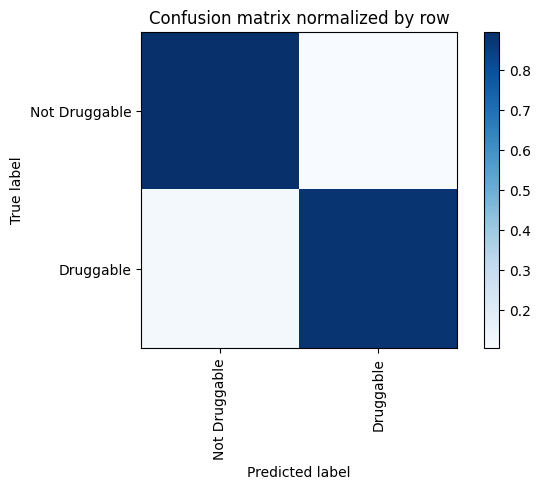

Overall accuracy: 0.888

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.890      0.895      0.892      0.519       1319|	 Druggable: 0.105,	
    Druggable       0.886      0.881      0.883      0.481       1223|	 Not Druggable: 0.119,	

----------------------------------------------------------------------------------------------------
  avg / total       0.888      0.888      0.888        1.0       2542|	      

{'accuracy': 0.8878835562549174, 'precision': 0.887792604389934, 'recall': 0.8876192784617798, 'f1': 0.8876991794492615, 'sensitivity': 0.8806214227309894, 'specificity': 0.8946171341925702}



Model :- ExtraTreesClassifier, DataType :- RSpolar


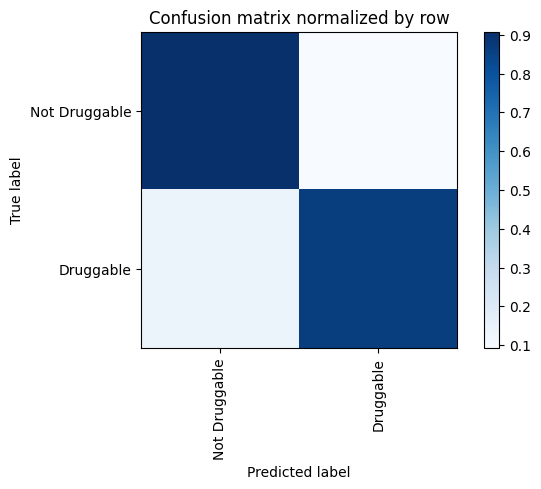

Overall accuracy: 0.887

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.879      0.908      0.893      0.519       1319|	 Druggable: 0.092,	
    Druggable       0.897      0.865      0.881      0.481       1223|	 Not Druggable: 0.135,	

----------------------------------------------------------------------------------------------------
  avg / total       0.887      0.887      0.887        1.0       2542|	      

{'accuracy': 0.8870967741935484, 'precision': 0.8877323975210931, 'recall': 0.886295770291054, 'f1': 0.8867581754312766, 'sensitivity': 0.8650858544562551, 'specificity': 0.9075056861258529}



Model :- ExtraTreesClassifier, DataType :- RSsecond


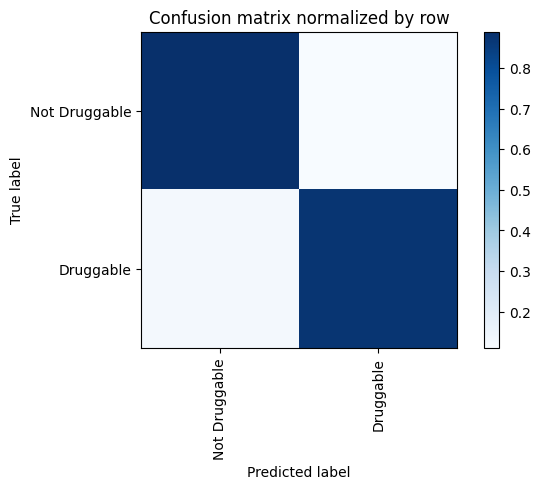

Overall accuracy: 0.882

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.883      0.890      0.887      0.519       1319|	 Druggable: 0.110,	
    Druggable       0.880      0.873      0.877      0.481       1223|	 Not Druggable: 0.127,	

----------------------------------------------------------------------------------------------------
  avg / total       0.882      0.882      0.882        1.0       2542|	      

{'accuracy': 0.8819826907946499, 'precision': 0.8819163104491907, 'recall': 0.8816653514239646, 'f1': 0.8817771196404387, 'sensitivity': 0.8732624693376942, 'specificity': 0.890068233510235}



Model :- ExtraTreesClassifier, DataType :- RScharge


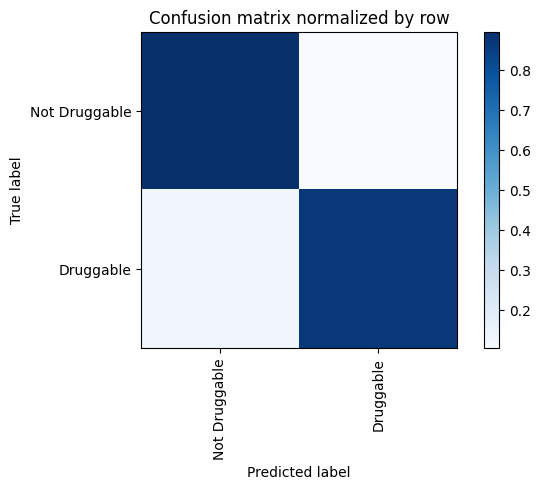

Overall accuracy: 0.882

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.880      0.895      0.888      0.519       1319|	 Druggable: 0.105,	
    Druggable       0.885      0.868      0.877      0.481       1223|	 Not Druggable: 0.132,	

----------------------------------------------------------------------------------------------------
  avg / total       0.882      0.882      0.882        1.0       2542|	      

{'accuracy': 0.8823760818253343, 'precision': 0.8825149031296573, 'recall': 0.8818658923575617, 'f1': 0.8821177420508055, 'sensitivity': 0.8683565004088307, 'specificity': 0.8953752843062927}



Model :- ExtraTreesClassifier, DataType :- RSDHP


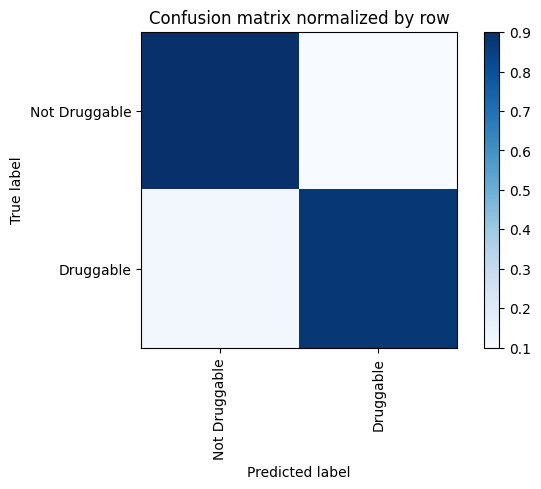

Overall accuracy: 0.889

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.887      0.901      0.894      0.519       1319|	 Druggable: 0.099,	
    Druggable       0.891      0.876      0.883      0.481       1223|	 Not Druggable: 0.124,	

----------------------------------------------------------------------------------------------------
  avg / total       0.889      0.889      0.889        1.0       2542|	      

{'accuracy': 0.8886703383162864, 'precision': 0.8887910696103509, 'recall': 0.8881988944522381, 'f1': 0.8884339899892604, 'sensitivity': 0.8757154538021259, 'specificity': 0.9006823351023503}



Model :- ExtraTreesClassifier, DataType :- Combine


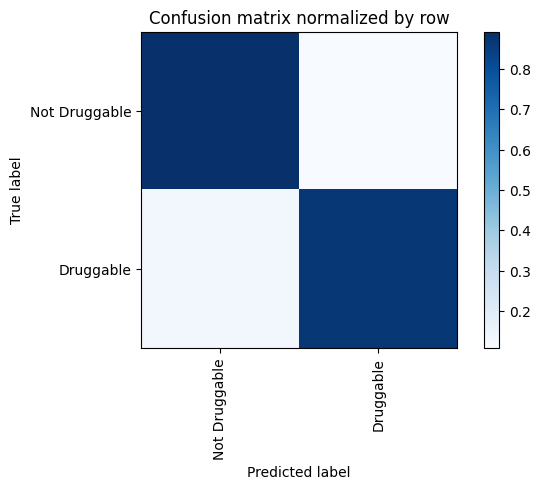

Overall accuracy: 0.880

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.879      0.892      0.885      0.519       1319|	 Druggable: 0.108,	
    Druggable       0.881      0.868      0.874      0.481       1223|	 Not Druggable: 0.132,	

----------------------------------------------------------------------------------------------------
  avg / total       0.880      0.880      0.880        1.0       2542|	      

{'accuracy': 0.8800157356412274, 'precision': 0.8800765013482711, 'recall': 0.8795616863291835, 'f1': 0.8797696656560502, 'sensitivity': 0.8675388389206868, 'specificity': 0.8915845337376801}



Model :- ExtraTreesClassifier, DataType :- DPC_RSDHP_RSacid_RSpolar_RSsecond_RScharge


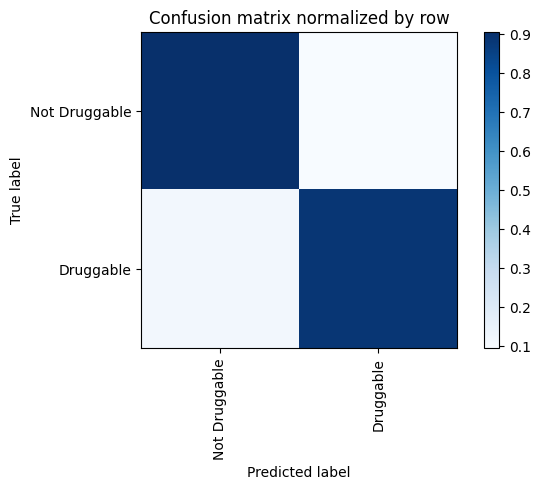

Overall accuracy: 0.895

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Not Druggable       0.893      0.905      0.899      0.519       1319|	 Druggable: 0.095,	
    Druggable       0.896      0.883      0.890      0.481       1223|	 Not Druggable: 0.117,	

----------------------------------------------------------------------------------------------------
  avg / total       0.895      0.895      0.895        1.0       2542|	      

{'accuracy': 0.8945712037765539, 'precision': 0.894654844406099, 'recall': 0.8941528214900532, 'f1': 0.8943587364284155, 'sensitivity': 0.8830744071954211, 'specificity': 0.9052312357846853}





In [6]:
for feat_type in X_data.keys():
    print(f"Model :- {config['model_type']}, DataType :- {feat_type}")
    
    os.makedirs(os.path.join(config["model_save_loc"],f"{config['model_type']}_{feat_type}"),exist_ok=True)
    model_dir = os.path.join(config["model_save_loc"],f"{config['model_type']}_{feat_type}")
    
    X,y = X_data[feat_type],train_data.targets
    X,y = shuffle(X,y,random_state=config["random_seed"])
    X = data_pipelines[feat_type].fit_transform(X,y)
    
    clf = ExtraTreesClassifier()
    y_pred = cross_val_predict(clf, X, y, cv=5)
    
    result_values = action_evaluator(y_pred,y,class_names=["Not Druggable","Druggable"],save_outputs=model_dir)
    
    clf.fit(X,y)
    
    print(result_values)
    joblib.dump(data_pipelines[feat_type], os.path.join(model_dir,"pipeline.sav"))
    joblib.dump(clf, os.path.join(model_dir,"model_save.sav"))
    print("\n\n")